In [1]:
from random import gauss
import os 
import sys
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import yfinance as yf
sys.path.insert(2,'..')
import functions
import xgboost as xgb
from sklearn import preprocessing
import annualized_rv as arv
from sklearn.model_selection import TimeSeriesSplit


from pytorch_forecasting import Baseline, TemporalFusionTransformer, TimeSeriesDataSet
from pytorch_forecasting.data import GroupNormalizer
from pytorch_forecasting.metrics import MAE, SMAPE, PoissonLoss, QuantileLoss
from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters

In [2]:
aaplHistIV = pd.read_pickle('historicImpliedVolData/aapl_mean_iv_2017_2022.pkl')
googHistIV = pd.read_pickle('historicImpliedVolData/goog_mean_iv_2017_2022.pkl')
msftHistIV = pd.read_pickle('historicImpliedVolData/msft_mean_iv_2017_2022.pkl')
ndxHistIV = pd.read_pickle('historicImpliedVolData/ndx_mean_iv_2017_2022.pkl')
spyHistIV = pd.read_pickle('historicImpliedVolData/spc_mean_iv_2017_2022.pkl')


In [3]:
spyHistIV.rename(columns = {'date':'Date'},inplace = True) #renaming date column to Date for consistency
spyHistIV.set_index('Date',inplace = True,drop = True) #setting index to date

In [4]:
#grab spy  from yfinance

spyHistory = yf.download('^GSPC', start='2016-01-01', end='2023-12-31')
#calculate realised vol
window =21 #realisedVol window size

spyHistory['DailyReturn'] = np.log(spyHistory['Adj Close']/spyHistory['Adj Close'].shift(1))

spyHistory['21dRealisedVol'] = spyHistory['DailyReturn'].rolling(window=window).std() * np.sqrt(252)
spyHistory['next_day_realised_vol'] = spyHistory['21dRealisedVol'].shift(-1)


[*********************100%%**********************]  1 of 1 completed


In [5]:
historicIVSeries = spyHistIV['average_iv']
nextDayRealVol = spyHistory['next_day_realised_vol']['2017':'2021'] 
historicVolumeSeries = spyHistory['Volume'].rolling(21).mean()['2017':'2021']
dailyReturnSeries= spyHistory['DailyReturn']['2017':'2021']
dailyRealisedVolSeries = spyHistory['21dRealisedVol']['2017':'2021']


df_combined = pd.concat([historicIVSeries,dailyReturnSeries,dailyRealisedVolSeries,historicVolumeSeries,nextDayRealVol], axis=1)



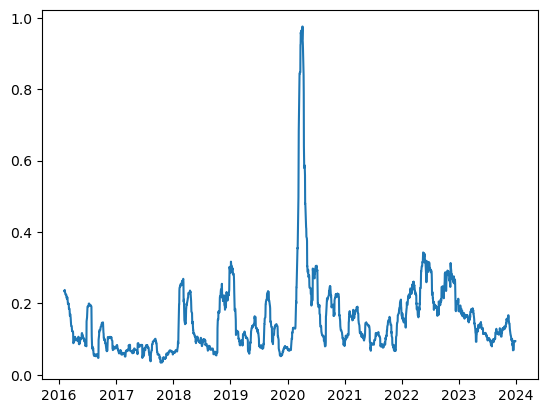

In [6]:
plt.plot(spyHistory['DailyReturn'].rolling(window=21).std()* np.sqrt(252) )


In [7]:
df_combined = pd.concat([historicIVSeries,dailyReturnSeries,dailyRealisedVolSeries,historicVolumeSeries,nextDayRealVol], axis=1)
df_combined.reset_index(inplace=True)
df_combined['time_idx'] = df_combined.index



In [8]:
df_combined

,Date,average_iv,DailyReturn,21dRealisedVol,Volume,next_day_realised_vol,time_idx
0,2017-01-03,0.180221,0.008451,0.082359,3.526195e+09,0.083565,0
1,2017-01-04,0.157412,0.005706,0.083565,3.525553e+09,0.082577,1
2,2017-01-05,0.167569,-0.000771,0.082577,3.520150e+09,0.082610,2
3,2017-01-06,0.132018,0.003511,0.082610,3.495617e+09,0.072379,3
4,2017-01-09,0.142141,-0.003555,0.072379,3.434458e+09,0.072173,4
...,...,...,...,...,...,...,...
1254,2021-12-27,0.199091,0.013744,0.210861,4.559823e+09,0.192429,1254
1255,2021-12-28,0.199753,-0.001011,0.192429,4.521262e+09,0.188094,1255
1256,2021-12-29,0.179895,0.001401,0.188094,4.455876e+09,0.173646,1256
1257,2021-12-30,0.194696,-0.002994,0.173646,4.289160e+09,0.167049,1257


In [9]:
max_pred_length = 1
max_encoder_length = 60
df_combined['group'] = 'constant_group' # needed constant group for group_id

training = TimeSeriesDataSet(
    df_combined,
    time_idx="time_idx",
    target="next_day_realised_vol",
    group_ids = ["group"],
    min_encoder_length=max_encoder_length // 2,  # keep encoder length long (as it is in the validation set)
    max_encoder_length=max_encoder_length,
    min_prediction_length=1,
    max_prediction_length=max_pred_length,
    time_varying_unknown_reals=["average_iv","DailyReturn","21dRealisedVol","Volume"],
    add_relative_time_idx=True,
    add_target_scales=True,
    add_encoder_length=True,
)

In [14]:
validation = TimeSeriesDataSet.from_dataset(training, df_combined, predict=True, stop_randomization=True)


In [15]:
# create dataloaders for model
batch_size = 128  # set this between 32 to 128
train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=0)
val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size * 10, num_workers=0)


In [19]:
import pytorch_lightning as pl


In [23]:
pl.seed_everything(42)
trainer = pl.Trainer(
    accelerator="cpu",
    # clipping gradients is a hyperparameter and important to prevent divergance
    # of the gradient for recurrent neural networks
    gradient_clip_val=0.1,
)

tft = TemporalFusionTransformer.from_dataset(
    training,
    # not meaningful for finding the learning rate but otherwise very important
    learning_rate=0.03,
    hidden_size=8,  # most important hyperparameter apart from learning rate
    # number of attention heads. Set to up to 4 for large datasets
    attention_head_size=1,
    dropout=0.1,  # between 0.1 and 0.3 are good values
    hidden_continuous_size=8,  # set to <= hidden_size
    loss=QuantileLoss(),
    optimizer="Ranger"
    # reduce learning rate if no improvement in validation loss after x epochs
    # reduce_on_plateau_patience=1000,
)
print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

Seed set to 42
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Number of parameters in network: 7.2k


C:\Users\Ahmed\miniconda3\envs\myenv\Lib\site-packages\pytorch_lightning\trainer\setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
C:\Users\Ahmed\miniconda3\envs\myenv\Lib\site-packages\pytorch_lightning\utilities\parsing.py:208: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
C:\Users\Ahmed\miniconda3\envs\myenv\Lib\site-packages\pytorch_lightning\utilities\parsing.py:208: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.


In [24]:
# find optimal learning rate
from lightning.pytorch.tuner import Tuner

res = Tuner(trainer).lr_find(
    tft,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
    max_lr=10.0,
    min_lr=1e-6,
)

print(f"suggested learning rate: {res.suggestion()}")
fig = res.plot(show=True, suggest=True)
fig.show()

C:\Users\Ahmed\miniconda3\envs\myenv\Lib\site-packages\pytorch_lightning\loops\utilities.py:73: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.


NotImplementedError: Support for `training_epoch_end` has been removed in v2.0.0. `TemporalFusionTransformer` implements this method. You can use the `on_train_epoch_end` hook instead. To access outputs, save them in-memory as instance attributes. You can find migration examples in https://github.com/Lightning-AI/lightning/pull/16520.